In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')


In [8]:

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


In [9]:

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [10]:

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)


In [11]:
y_test

tensor([[[301.],
         [356.],
         [348.],
         [355.]],

        [[356.],
         [348.],
         [355.],
         [422.]],

        [[348.],
         [355.],
         [422.],
         [465.]],

        [[355.],
         [422.],
         [465.],
         [467.]],

        [[422.],
         [465.],
         [467.],
         [404.]],

        [[465.],
         [467.],
         [404.],
         [347.]],

        [[467.],
         [404.],
         [347.],
         [305.]],

        [[404.],
         [347.],
         [305.],
         [336.]],

        [[347.],
         [305.],
         [336.],
         [340.]],

        [[305.],
         [336.],
         [340.],
         [318.]],

        [[336.],
         [340.],
         [318.],
         [362.]],

        [[340.],
         [318.],
         [362.],
         [348.]],

        [[318.],
         [362.],
         [348.],
         [363.]],

        [[362.],
         [348.],
         [363.],
         [435.]],

        [[348.],
   

Epoch 0: train RMSE 225.9490, test RMSE 425.2055
Epoch 100: train RMSE 173.2590, test RMSE 369.8228
Epoch 200: train RMSE 134.4888, test RMSE 326.9932
Epoch 300: train RMSE 104.2190, test RMSE 289.8711
Epoch 400: train RMSE 82.7602, test RMSE 257.8726
Epoch 500: train RMSE 63.5980, test RMSE 228.2204
Epoch 600: train RMSE 50.4933, test RMSE 201.8946
Epoch 700: train RMSE 40.8157, test RMSE 178.0105
Epoch 800: train RMSE 34.3344, test RMSE 157.2466
Epoch 900: train RMSE 29.6431, test RMSE 139.9697
Epoch 1000: train RMSE 26.6614, test RMSE 125.4444
Epoch 1100: train RMSE 24.8987, test RMSE 114.0902
Epoch 1200: train RMSE 23.1994, test RMSE 104.3082
Epoch 1300: train RMSE 23.6936, test RMSE 96.0132
Epoch 1400: train RMSE 21.5017, test RMSE 91.3067
Epoch 1500: train RMSE 21.1155, test RMSE 85.6960
Epoch 1600: train RMSE 20.4781, test RMSE 82.5733
Epoch 1700: train RMSE 20.0381, test RMSE 79.0845
Epoch 1800: train RMSE 19.7705, test RMSE 77.2696
Epoch 1900: train RMSE 19.3670, test RMSE 74.

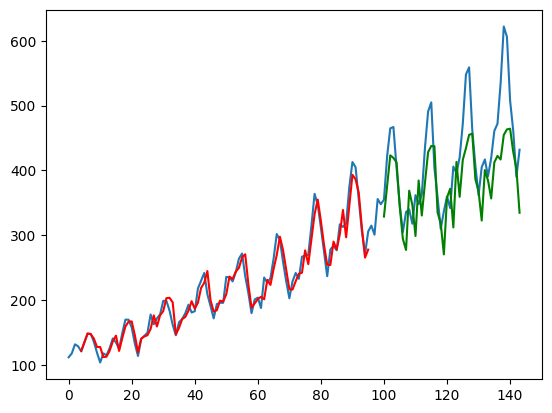

In [12]:

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()